In [1]:
import scipy.io as scio
import pandas as pd
import numpy as np
import os
from pandas import Series,DataFrame
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn import  metrics 
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.metrics import accuracy_score  
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

import time
import cProfile
import psutil
%load_ext memory_profiler
sns.set()

/Users/ashleyculver/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#set lists for final graph comparison
model_time = [] #how much time required to train model
model_accuracy = [] #test accuracy
model_similarity = [] #percentage test_accuracy/train_accuracy
names = [] #names of models

### Set Path 

In [3]:
#Fall2019-proj3-sec1--proj3-sec1-grp2
pwd = os.path.dirname(os.path.dirname(os.getcwd()))
    
# set the working directory of output
checkpoint_wd = os.path.join(pwd, "output", "checkpoint")
if not os.path.exists(checkpoint_wd):
    os.makedirs(checkpoint_wd)

## Train 

### Data Preprocessing 

In [4]:
scaler = MinMaxScaler(feature_range = (0,1))

In [5]:
random.seed(3345)

In [6]:
def distance_feature(x): # calcuate distance between points, choose uprigt triangle
    #sqrt(dx^2+dy^2)
    a = (x[None, :, :] - x[:, None, :])
    b = np.linalg.norm(a, axis=2)
    return b[np.triu_indices(78, 1)] # feature size (78-1)(78-2) /2 

In [7]:
def euc_distance_feature(x): # instead of distance, keep two dimensional distance vector
    #(dx,dy)
    a = (x[None, :, :] - x[:, None, :])
    index = np.triu_indices(78, 1)
    b = a[index]
    return b.reshape((-1,)) # feature size (78-1)(78-2) /2 * 2

In [8]:
df = pd.read_csv("../../data/train_set/label.csv")
labels = df["emotion_idx"].tolist()

In [9]:
data = list()
for i in range(1, 2501):
    name = "../../data/train_set/points/%04d.mat" % i
    dic = scio.loadmat(name)
    if "faceCoordinatesUnwarped" in dic:
        data.append(dic["faceCoordinatesUnwarped"])
    else:
        data.append(dic["faceCoordinates2"])

In [10]:
# shuffle data
data, labels = shuffle(data, labels, random_state=0)

In [11]:
x_train, x_test, train_y, test_y = train_test_split(data, labels, test_size=0.2)

### First we try Euclidian distance as features 

In [12]:
train_x = [euc_distance_feature(d) for d in x_train] #(dx,dy)
test_x = [euc_distance_feature(d) for d in x_test]

In [13]:
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

### Base Line Model: KNN

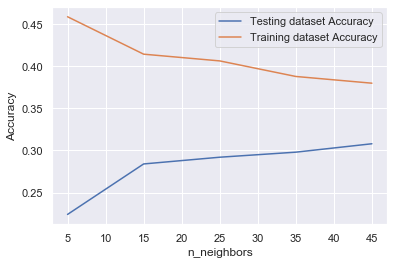

In [14]:
neighbors = np.arange(5, 50, 10) 
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 

start = time.time() #start time
# Loop over K values 
for i, k in enumerate(neighbors): 
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(train_x, train_y) 
      
    # Compute traning and test data accuracy 
    train_accuracy[i] = knn.score(train_x, train_y) 
    test_accuracy[i] = knn.score(test_x, test_y) 

#Generate plot 
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 
  
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 
plt.show() 

In [15]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(train_x, train_y) 

end = time.time() #end time
print("Training Time:","%s seconds"%(end - start))

time_KN_euc = end - start #time to train model
model_time.append(time_KN_euc) #add model info to final comparison graph
names.append("KNN Euclid baseline")

Training Time: 288.61216473579407 seconds


In [16]:
print("Training dataset Accuracy")
train_accuracy = knn.score(train_x, train_y) 
print(train_accuracy)

print("Testing dataset Accuracy")
knn_preds = knn.predict(test_x)
test_accuracy = knn.score(test_x, test_y) 
print(test_accuracy)

acc_diff_KN_euclid = 100*test_accuracy/train_accuracy
model_accuracy.append(100*test_accuracy)
model_similarity.append(acc_diff_KN_euclid)

Training dataset Accuracy
0.4145
Testing dataset Accuracy
0.284


### Second we try the distance as features 

In [17]:
train_x = [distance_feature(d) for d in x_train] #sqrt(dx^2+dy^2)
test_x = [distance_feature(d) for d in x_test]

In [18]:
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

### Base Line Model: KNN

In [ ]:
neighbors = np.arange(5, 50, 10) 
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 

start = time.time() #start time
# Loop over K values 
for i, k in enumerate(neighbors): 
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(train_x, train_y) 
      
    # Compute traning and test data accuracy 
    train_accuracy[i] = knn.score(train_x, train_y) 
    test_accuracy[i] = knn.score(test_x, test_y) 

#Generate plot 
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 
  
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 
plt.show() 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(train_x, train_y) 

end = time.time() #end time
print("Training Time:","%s seconds"%(end - start))

time_KN = end - start #time to train model
model_time.append(time_KN) #add model info to final comparison graph
names.append("KNN Baseline")

In [ ]:
print("Training dataset Accuracy")
train_accuracy = knn.score(train_x, train_y) 
print(train_accuracy)

print("Testing dataset Accuracy")
knn_preds = knn.predict(test_x)
test_accuracy = knn.score(test_x, test_y) 
print(test_accuracy)

acc_diff_KN = 100*test_accuracy/train_accuracy
model_accuracy.append(100*test_accuracy)
model_similarity.append(acc_diff_KN)

We see that the distance formula sqrt(dx^2+dy^2) produces a higher accuracy rate than the Euclidian distance formula. Therefore, we choose the distance formula to use in evaluation of future models.

In [ ]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(train_x)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [ ]:
pca = PCA(n_components=80).fit(train_x)
train_x_reduce = pca.transform(train_x)

In [ ]:
start = time.time() #start time

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(train_x_reduce, train_y) 

end = time.time() #end time
print("Training Time:","%s seconds"%(end - start))

time_KN_pca = end - start #time to train model
model_time.append(time_KN_pca) #add model info to final comparison graph
names.append("KNN PCA")

In [ ]:
print("Training dataset Accuracy")
train_accuracy = knn.score(train_x_reduce, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
test_accuracy = knn.score(pca.transform(test_x), test_y) 
print(test_accuracy)

acc_diff_KN_pca = 100*test_accuracy/train_accuracy
model_accuracy.append(100*test_accuracy)
model_similarity.append(acc_diff_KN_pca)

### GBM

In [ ]:
start = time.time() #start time

gbm = GradientBoostingClassifier(learning_rate=0.01,n_estimators=30,random_state=10).fit(train_x, train_y)
end = time.time() #end time
print("Training Time:","%s seconds"%(end - start))

time_gbm = end - start #time to train model
model_time.append(time_gbm) #add model info to final comparison graph
names.append("GBM")

In [ ]:
print("Training dataset Accuracy")
train_accuracy = gbm.score(train_x, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
gbm_preds = gbm.predict(test_x)
test_accuracy = gbm.score(test_x, test_y) 
print(test_accuracy)

acc_diff_gbm = 100*test_accuracy/train_accuracy
model_accuracy.append(100*test_accuracy)
model_similarity.append(acc_diff_gbm)

### Logistic Regression

In [ ]:
start = time.time() #start time
param_grid = {'C': [0.001, 0.01, 1, 5, 10, 25] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
GridSearchCV(cv=None,
             estimator=LogisticRegression(C=1.0, intercept_scaling=1,
                                          dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
             param_grid={'C': [0.001, 0.01, 1, 5, 10, 25]})

best_clf = clf.fit(train_x, train_y)

end = time.time() #end time
print("Training Time:","%s seconds"%(end - start))
time_logreg = end - start #time to train model

model_time.append(time_logreg) #add model info to final comparison graph
names.append("Log Regr")

In [ ]:
print("Training dataset Accuracy")
train_accuracy = best_clf.score(train_x, train_y)
print(train_accuracy)
print("Testing dataset Accuracy")
test_accuracy = best_clf.score(test_x, test_y)
print(test_accuracy)

acc_diff_logreg = 100*test_accuracy/train_accuracy
model_accuracy.append(100*test_accuracy)
model_similarity.append(acc_diff_logreg)

### Random Forest

In [ ]:
start = time.time() #start time

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10, 20],
    'max_features': [2, 3],
    'min_samples_leaf': [10, 15],
    'min_samples_split': [10, 12],
    'n_estimators': [200, 400]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
best_rf = rf.fit(train_x, train_y)

end = time.time() #end time
print("Training Time:","%s seconds"%(end - start))

time_forest = end - start #time to train model
model_time.append(time_forest) #add model info to final comparison graph
names.append("Random Forest")

In [ ]:
print("Training dataset Accuracy")
train_accuracy = best_rf.score(train_x, train_y)
print(train_accuracy)
print("Testing dataset Accuracy")
test_accuracy = best_rf.score(test_x, test_y)
print(test_accuracy)

acc_diff_forest = 100*test_accuracy/train_accuracy
model_accuracy.append(100*test_accuracy)
model_similarity.append(acc_diff_forest)

### Xgboost

In [ ]:
dtrain = xgb.DMatrix(train_x, label=train_y)
dtest = xgb.DMatrix(test_x, label=test_y)

In [ ]:
param = {'booster':'gbtree',
'objective': 'multi:softmax', 
'num_class':23,
'n_estimators':500,
'max_depth':20, 
'alpha': 3,
'gamma': 1,
'silent': 1,
'subsample': 0.8,
'eta': 0.1,
'learning_rates': 0.03}
num_round= 5

start = time.time() #start time
bst = xgb.train(param, dtrain, num_round)

end = time.time() #end time
print("Training Time:","%s seconds"%(end - start))

time_xgboost = end - start #time to train model
model_time.append(time_xgboost) #add model info to final comparison graph
names.append("xgboost")

print("Training dataset Accuracy")
train_preds = bst.predict(dtrain)
train_accuracy = accuracy_score(train_y, train_preds) 
print(train_accuracy)

In [ ]:
print("Testing dataset Accuracy")
xgb_preds = bst.predict(dtest)
test_accuracy = accuracy_score(test_y, xgb_preds) 
print(test_accuracy)

acc_diff_xgboost = 100*test_accuracy/train_accuracy
model_accuracy.append(100*test_accuracy)
model_similarity.append(acc_xgboost)

### Model Ensembling

#### Method 1: Average

In [ ]:
preds = (lr_preds+knn_preds+rf_preds+gbm_preds)/4
preds = np.ceil(preds)
test_accuracy = accuracy_score(test_y, preds) 
print ("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

In [ ]:
preds = (lr_preds+rf_preds+gbm_preds)/3
preds = np.ceil(preds)
test_accuracy = accuracy_score(test_y, preds) 
print ("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

In [ ]:
preds = (lr_preds+gbm_preds)/2
preds = np.ceil(preds)
test_accuracy = accuracy_score(test_y, preds) 
print ("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

#### Method 2: Stacking

In [ ]:
#Method 2: Stacking
from sklearn.model_selection import KFold
def stacking(clf, x_train, y_train, x_test, n_folds=8):
    train_num, test_num = x_train.shape[0], x_test.shape[0]
    second_level_train_set = np.zeros((train_num,))
    second_level_test_set = np.zeros((test_num,))
    test_nfolds_sets = np.zeros((test_num, n_folds))
    kf = KFold(n_splits=n_folds)

    for i,(train_index, test_index) in enumerate(kf.split(x_train)):
        x_tra, y_tra = x_train[train_index], y_train[train_index]
        x_tst, y_tst =  x_train[test_index], y_train[test_index]

        clf.fit(x_tra, y_tra)

        second_level_train_set[test_index] = clf.predict(x_tst)
        test_nfolds_sets[:,i] = clf.predict(x_test)

    second_level_test_set[:] = test_nfolds_sets.mean(axis=1)
    return second_level_train_set, second_level_test_set

In [ ]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

In [ ]:
gbm_model = GradientBoostingClassifier(learning_rate=0.01,n_estimators=30,random_state=10)
lr_model = LogisticRegression(max_iter=300, penalty = "l2", solver='lbfgs', multi_class='multinomial', n_jobs=-1)

In [ ]:
train_sets = []
test_sets = []
for clf in [gbm_model,lr_model]:
    train_set, test_set = stacking(clf, train_x, train_y, test_x)
    train_sets.append(train_set)
    test_sets.append(test_set)

meta_train = np.concatenate([result_set.reshape(-1,1) for result_set in train_sets], axis=1)
meta_test = np.concatenate([y_test_set.reshape(-1,1) for y_test_set in test_sets], axis=1)

In [ ]:
model = DecisionTreeClassifier(max_depth = 5)
model.fit(train_x,train_y)
print(model.score(train_x, train_y))
model.score(test_x, test_y)

###Heuristics Plot

In [ ]:
#Plot time, model similarity, modek accuracy
plt.xticks(rotation='70')
plt.plot(names, model_time, label = 'Model Time to Run (s)')
plt.plot(names, model_similarity, label = 'Model Similarity (% test of train)')
plt.plot(names, model_accuracy, label = 'Model Accuracy (% test accuracy)')

# Generate plot   
plt.legend() 
plt.xlabel('Model Type') 
plt.ylabel('Time (s), Percentage Accuracy ') 
plt.title('Model Heuristics')
plt.show() 

Save Model

In [ ]:
joblib.dump(clf, checkpoint_wd+"/train_model.m")

## Test 

In [ ]:
pwd = os.path.dirname(os.path.dirname(os.getcwd()))
checkpoint_wd = os.path.join(pwd, "output", "checkpoint")

In [ ]:
# read model
clf = joblib.load(checkpoint_wd+"/train_model.m")

In [ ]:
# read label
data_path = os.path.join(pwd, "data", "test_set")
df = pd.read_csv(data_path +"/label.csv")
labels = df["emotion_idx"].tolist()

In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))

In [ ]:
def distance_feature(x): # calcuate distance between points, choose uprigt triangle
    #sqrt(dx^2+dy^2)
    a = (x[None, :, :] - x[:, None, :])
    b = np.linalg.norm(a, axis=2)
    return b[np.triu_indices(78, 1)] # feature size (78-1)(78-2) /2 

In [ ]:
# read point
data = list()
for i in range(1, 2501):
    name = "../../data/test_set/points/%04d.mat" % i
    dic = scio.loadmat(name)
    if "faceCoordinatesUnwarped" in dic:
        data.append(dic["faceCoordinatesUnwarped"])
    else:
        data.append(dic["faceCoordinates2"])

In [ ]:
test_x = [distance_feature(d) for d in data]
scaler.fit(test_x)
test_x = scaler.transform(test_x)

In [ ]:
preds = clf.predit(test_x)
test_accuracy = accuracy_score(labels, preds) 
print ("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))